## COMP5625M Assessment 2 - Image Caption Generation [100 marks]

<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>

The maximum marks for each part are shown in the section headers. The overall assessment carries a total of 100 marks.

This assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!** 

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

mm22mkm

Your full name:

Mani Krishna Mandepudi

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
import cv2
import re
import numpy as np
import nltk
import random
import warnings

from IPython.display import HTML
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

warnings.filterwarnings("ignore")

C:\Users\mande\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


ModuleNotFoundError: No module named 'cv2'

Detect which device (CPU/GPU) to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment). 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) --> 


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features. 


### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [ ]:
class EncoderCNN(nn.Module):
    """
    EncoderCNN loads a pretrained ResNet-50 model, removes the last fully connected layer, and returns the flattened features 
    of the last convolutional layer. The feature vectors are normalized using L2 normalization.
    
    Input:
    - images: tensor - a batch of input images
    
    Output:
    - features: tensor - a tensor of shape (batch_size, embed_size) containing the normalized feature vectors of 
                          the input images
    
    """
    
    def __init__(self):
        super(EncoderCNN, self).__init__()
        
        # Loading the pretrained ResNet-50 model
        resnet = models.resnet50(pretrained=True)
        
        # Removing the last fully connected layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        
    def forward(self, images):
        
        # No graidents are added
        with torch.no_grad():
            features = self.resnet(images)
        
        # Flatten the features and normalize
        features = features.view(features.size(0), -1)
        features = F.normalize(features)
        
        return features

In [ ]:
# Creating an instance of the EncoderCNN class
encoder = EncoderCNN()

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [ ]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [ ]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/kaggle/input/cocodataset/coco_subset_meta.csv")

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

In [7]:
IMAGE_DIR = "/kaggle/input/cocodataset/coco/images"

class COCOImagesDataset(Dataset):
    """
    COCOImagesDataset is a PyTorch Dataset class for loading the COCO images.
    
    Args:
        df : Coco Images Dataframe
        transform : A transform that takes in a PIL image and returns a transformed version of it.

    Returns:
        tuple: Tuple containing the loaded and transformed image and the name of the image file.

    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        """
            Retrieves the image at the given index and returns the Tuple containing the loaded and 
            transformed image and the name of the image file
        """
        filename = self.df.iloc[index]['file_name']
        image_path = os.path.join(IMAGE_DIR, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image)
        return image, filename
    
    def __len__(self):
        # Returns the total number of images in the dataset.
        return len(self.df)

In [8]:
# Defining a batch size for the Coco Image data loader
batch_size = 64

# Creating an instance of the COCOImagesDataset class and applying the specified transforms
dataset = COCOImagesDataset(df_unique_files, data_transform)

# Creating a PyTorch DataLoader object to load the dataset in batches
data_loader = DataLoader(dataset=dataset, 
                         batch_size=batch_size, 
                         shuffle=False,
                         num_workers=2,
                         generator=torch.Generator().manual_seed(0))

In [9]:
# Creating an empty dictionary to store the extracted features
features_map = dict()

with torch.no_grad():
    # Model is set to eval mode
    encoder.eval()
    encoder.to(device)
    # Extracting the features of each batch of dataloader.
    for images, image_ids in tqdm(data_loader):
        images = images.to(device)

        # Extract features for the batch of images using the encoder model
        features = encoder(images)
        
        # Saving the features with filename in the feature_map dictionary
        for i in range(features.shape[0]):
            image_id = image_ids[i]
            feature = features[i].cpu().numpy()
            features_map[image_id] = feature

# Save the extracted features to a file using torch.save()
torch.save(features_map, 'features.pt')

  0%|          | 0/80 [00:00<?, ?it/s]

## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [10]:
import json

# loading captions for training
with open('/kaggle/input/cocodataset/coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])

In [11]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("/kaggle/input/cocodataset/coco_subset_meta.csv")
# --> your code here! - name the new dataframe as "new_file"

# Merging the dataframes based on the "image_id" column
new_file = df.merge(coco_subset[['id', 'file_name']], left_on='image_id', right_on='id', how='inner')

# Droping the unnecessary columns and rename the remaining ones
new_file = new_file.drop(columns=['id_y'])
new_file = new_file.rename(columns={'id_x': 'id'})

In [12]:
new_file.head(10)

,image_id,id,caption,file_name
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg
5,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg
6,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg
7,410627,8523,A smiling man is cooking in his kitchen.,000000410627.jpg
8,410627,8649,A man smiles as he stirs his food in the pot.,000000410627.jpg
9,410627,826886,A boy smiles while holding a pot and spoon.,000000410627.jpg


#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [13]:
new_file["clean_caption"] = ""

def gen_clean_captions_df(df):
    """
    The column clean_caption_column is created 
    clean_caption column is created to the df after applying the following clea
    Takes a dataframe with a 'caption_text' column and generates a new column
    called '' that has the caption text cleaned up according to
    the following steps:
    1. Remove spaces in the beginning and at the end
    2. Convert to lower case
    3. Replace all non-alphabet characters with space
    4. Replace all continuous spaces with a single space

    Args:
        df (pandas.DataFrame): A dataframe with a 'caption_text' column

    Returns:
        pandas.DataFrame: The original dataframe with a new 'clean_caption' column
    """
    
    df['clean_caption'] = df['caption'].str.strip()
    df['clean_caption'] = df['clean_caption'].str.lower()
    df['clean_caption'] = df['clean_caption'].apply(lambda x: re.sub('[^a-z]+', ' ', x))
    df['clean_caption'] = df['clean_caption'].apply(lambda x: re.sub('\s+', ' ', x))

    return df

In [14]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.drop_duplicates(inplace = True)
new_file.head(10)

,image_id,id,caption,file_name,clean_caption
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg,an airplane with its landing wheels out landing
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg,a plane that is taking off at an airport
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg,a man takes a picture of an airplane taking off
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg,a large jet takes off from an airport runway
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg,the airplane is taking off on the runway at th...
5,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg,the young man is stirring his pot of food with...
6,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg,a man enjoys cooking food in a pan
7,410627,8523,A smiling man is cooking in his kitchen.,000000410627.jpg,a smiling man is cooking in his kitchen
8,410627,8649,A man smiles as he stirs his food in the pot.,000000410627.jpg,a man smiles as he stirs his food in the pot
9,410627,826886,A boy smiles while holding a pot and spoon.,000000410627.jpg,a boy smiles while holding a pot and spoon


#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [15]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [16]:
# split image ids into train/validation/test sets
train_ids, valid_ids, test_ids = split_ids(new_file['image_id'].unique(), train=0.7, valid=0.1, test=0.2)

# obtain corresponding rows from original dataframe
train_df = new_file[new_file['image_id'].isin(train_ids)]
valid_df = new_file[new_file['image_id'].isin(valid_ids)]
test_df = new_file[new_file['image_id'].isin(test_ids)]

#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [17]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [18]:
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df_ids:            
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # added isalpha function to get rid of numbers, symbols etc.
            if word.isalpha() and word in word_mapping:
                word_mapping[word] += 1
            elif word.isalpha():
                word_mapping[word] = 1

                
    # Create a vocab instance
    vocab = Vocabulary()

    # Add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Added if condition to ignore the minimum frequency
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)
        
    return vocab

In [19]:
#  Concatenating the train_df and valid_df to build the vocab 
all_ids = np.concatenate([train_df['image_id'].unique(), valid_df['image_id'].unique()])

# Building vocabulary for train set and validation set together
vocab = build_vocab(all_ids, new_file)

print("The total length of vocabulary for test and validation set is ", len(vocab))

The total length of vocabulary for test and validation set is  2103


#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [20]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
                Dataframe containing image filenames and their corresponding captions.
            features: image features
                A dictionary-like object where each key is an image filename (without the .jpg extension) and each value
                is a tensor of shape (1, 2048) containing the image features for that image.
            vocab: vocabulary wrapper
                A Vocabulary object containing the vocabulary of the captions.
        """
        self.df = df
        self.features = features
        self.vocab = vocab
        self.max_seq_len = MAX_SEQ_LEN  # maximum sequence length of captions
        
    def __getitem__(self, index):
        """
        Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length)
        """
        # get the image filename and caption at the given index
        row = self.df.iloc[index]
        img_filename = row['file_name']
        caption = row['clean_caption']
        
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())

        caption_ids = []
        caption_ids.append(self.vocab('<start>'))
        caption_ids.extend([self.vocab(token) for token in tokens if self.vocab(token) != self.vocab('<unk>')])
        caption_ids.append(self.vocab('<end>'))

        # pad the caption with <pad> tokens to make it of length MAX_SEQ_LEN
        caption_ids += [self.vocab('<pad>')] * (MAX_SEQ_LEN - len(caption_ids))

        # convert caption_ids list to a tensor
        caption_ids = torch.LongTensor(caption_ids)

        # get the true length of the caption (excluding padding)
        true_len = len(tokens) + 2

        # get the image features tensor
        image_features = self.features[img_filename]
        image_features = torch.Tensor(image_features)
        image_features = image_features.unsqueeze(0)

        return image_features, caption_ids, true_len
    
    def __len__(self):
        return len(self.df)

In [21]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: numpy ndarray of shape (1, 2048).
            - caption: torch tensor of shape (max_seq_len,).
    Returns:
        images: torch tensor of shape (batch_size, 1, 2048).
        targets: torch tensor of shape (batch_size, max_seq_len).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)

    # Separate image and caption tensors from the sorted data list.
    images, captions, length = zip(*data)
    
    # Convert images to tensor and merge (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)
    
    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), MAX_SEQ_LEN).long()
    for i, caption in enumerate(captions):
        end_idx = lengths[i]
        targets[i, :end_idx] = caption[:end_idx]
    lengths = torch.Tensor(lengths).long()

    return images, targets, lengths

In [22]:
# Load the saved features map
features_map = torch.load('features.pt')

# creating training datasets
dataset_train = COCO_Features(
    df = train_df,
    vocab = vocab,
    features = features_map,
)

# creating dataloaders for training sets
train_loader = DataLoader(
    dataset_train, 
    batch_size = 64, 
    shuffle = True, 
    collate_fn = caption_collate_fn,
    num_workers=2,
    generator=torch.Generator().manual_seed(0)
)

# creating validation datasets
dataset_valid = COCO_Features(
    df = valid_df,
    vocab = vocab,
    features = features_map,
)

# creating dataloaders for validation sets
val_loader = DataLoader(
    dataset_valid, 
    batch_size = 64,
    shuffle = False,
    collate_fn = caption_collate_fn,
    num_workers=2,
    generator=torch.Generator().manual_seed(0)
)

Load one batch of the training set and print out the shape of each returned Tensor.

In [23]:
# loading one batch of training data to print
features, captions, lengths = next(iter(train_loader))

# print the shape of each returned Tensor
print('Features shape:', features.shape)
print('Captions shape:', captions.shape)
print('Lengths shape:', lengths.shape)

Features shape: torch.Size([64, 1, 2048])
Captions shape: torch.Size([64, 47])
Lengths shape: torch.Size([64])


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [24]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """
        A decoder recurrent neural network (RNN) that takes image feature vectors and 
        generates captions.
        """
        super(DecoderRNN, self).__init__()
        
        self.max_seq_length = max_seq_length
        
        # Linear layer to resize        
        self.linear = nn.Linear(2048, embed_size)
        
        # batch normalisation         
        self.bn = nn.BatchNorm1d(embed_size, momentum = 0.01)
        
        # Eembedding layer         
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        # RNN Layeer
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        
        # linear layer         
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        features = features.view(features.size(0), -1)
        im_features = self.linear(features)
        im_features = self.bn(im_features)
       
        embeddings = self.embed(captions)
        
        # Concatenate image features and caption embeddings as input to the RNN
        inputs = torch.cat((im_features.unsqueeze(dim = 1), embeddings), dim = 1)
        
        # Pack padded sequences
        packed = pack_padded_sequence(inputs, lengths, batch_first=True)
        
        # Pass through RNN
        output, _ = self.rnn(packed)
        
        # Pass through output layer
        outputs = self.fc(output[0])
        
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = self.bn(self.linear(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)
            outputs = self.fc(hiddens.squeeze(1))
            _, predicted = outputs.max(1)              
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)        
        sampled_ids = torch.stack(sampled_ids, 1)
        return sampled_ids

In [25]:
# Creating an instance of the DecoderRNN class
decoder = DecoderRNN(len(vocab))
decoder = decoder.to(device)

#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [26]:
learning_rate = 0.0001
patience = 5

# Initializing the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)


train_losses = []
val_losses = []
best_val_loss = float('inf')
counter = 0
early_stop = False
num_epochs = 50

# Training the decoder
for epoch in range(num_epochs):
    
    decoder.train()
    
    epoch_train_loss = 0.0
    
    for i, (features, captions, lengths) in enumerate(train_loader):
        
        features = features.to(device)
        captions = captions.to(device)
        
        # Reset the gradients
        decoder.zero_grad()
        
        # Forward pass
        outputs = decoder(features, captions, lengths)
        
        # Calculating the loss
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
        loss = criterion(outputs.view(-1, len(vocab)), targets)
        
        # Backward pass and Optimization
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
    # Calculating the average training loss for the epoch
    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)
        
        
    decoder.eval()
    with torch.no_grad():
        
        val_loss = 0
        for i, (features, captions, lengths) in enumerate(val_loader):
            
            features = features.to(device)
            captions = captions.to(device)
            
            
            outputs = decoder(features, captions, lengths)
            
            # Calculating the loss
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            loss = criterion(outputs.view(-1, len(vocab)), targets)
            
            # Forward pass
            val_loss += loss.item()
        
        # Calculating the average training loss for the epoch
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Checking if the current validation loss is the best so far to early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(decoder.state_dict(), 'decoder.pt')
        else:
            counter += 1
            
        if counter >= patience :
            print("Early stopping")
            early_stop = True
            break
    
    # print the current epoch and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
    
    if early_stop:
        break

# Saving the final model
torch.save(decoder.state_dict(), 'decoder_final.pt')

Epoch 1/50, Training Loss: 1.7562, Validation Loss: 1.2578
Epoch 2/50, Training Loss: 1.1487, Validation Loss: 1.1097
Epoch 3/50, Training Loss: 1.0016, Validation Loss: 0.9667
Epoch 4/50, Training Loss: 0.9440, Validation Loss: 0.9296
Epoch 5/50, Training Loss: 0.9058, Validation Loss: 0.8985
Epoch 6/50, Training Loss: 0.8733, Validation Loss: 0.8706
Epoch 7/50, Training Loss: 0.8418, Validation Loss: 0.8439
Epoch 8/50, Training Loss: 0.8104, Validation Loss: 0.8178
Epoch 9/50, Training Loss: 0.7831, Validation Loss: 0.7967
Epoch 10/50, Training Loss: 0.7603, Validation Loss: 0.7815
Epoch 11/50, Training Loss: 0.7406, Validation Loss: 0.7697
Epoch 12/50, Training Loss: 0.7234, Validation Loss: 0.7580
Epoch 13/50, Training Loss: 0.7080, Validation Loss: 0.7498
Epoch 14/50, Training Loss: 0.6939, Validation Loss: 0.7414
Epoch 15/50, Training Loss: 0.6799, Validation Loss: 0.7332
Epoch 16/50, Training Loss: 0.6677, Validation Loss: 0.7284
Epoch 17/50, Training Loss: 0.6556, Validation Lo

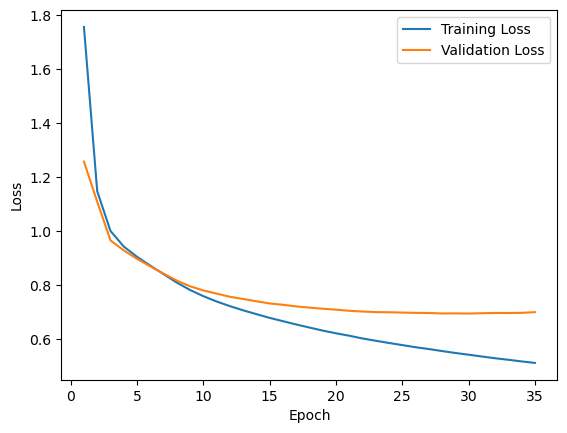

In [27]:
# plotting the training and validation losses
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### **Explanation of a graph**
The graph provides an overview of the training and validation loss for the Coco image dataset. The training process was conducted over 50 epochs, allowing the model to learn from the data. However, an interesting feature of the graph is the activation of early stopping. This mechanism is triggered when there is no improvement in the validation loss for the past 5 epochs, indicating that the model has reached a point of diminishing returns. This helps prevent overfitting and allows for more efficient training by stopping the process early when further training is not leading to better results. 

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

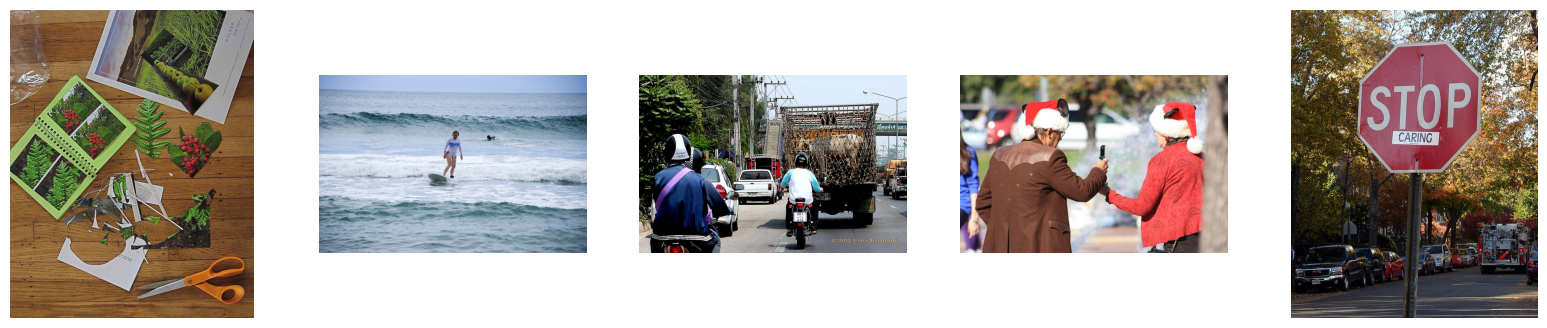

In [108]:
images_path = '/kaggle/input/cocodataset/coco/images/'

# Selecting five random unique filenames from the test_df 
random_filenames = random.sample(list(test_df['file_name'].unique()), 5)

# Loading the testing images
test_images_list = [Image.open(images_path + filename).convert('RGB') for filename in random_filenames]

# Displaying all the testing images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, image in enumerate(test_images_list):
    axes[i].imshow(image)
    axes[i].axis('off')
plt.show()

In [109]:
def generate_caption(features):
    """
    This function will return the Generated caption for the given features
    """
    generated_caption = []
    with torch.no_grad():
        # Moving features to device
        features = features.to(device)
        
        # Generating the caption using the sample function of the decoder instance
        sampled_ids = decoder.sample(features)
        # Converting the tokens into words
        sampled_caption = []
        for word_id in sampled_ids[0]:
            word = vocab.idx2word[word_id.item()]
            sampled_caption.append(word)
            if word == '<end>':
                break
        caption = ' '.join(sampled_caption[1:-1])
        generated_caption.append(caption)
    return generated_caption

Image:  1


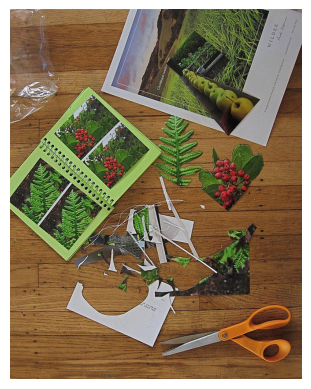

Generated caption :  ['a bunch of vegetables that are on a table']
Reference caption :  ['Cut up pictures of plants from magazines and a pair of scissors.', 'Scissors and cut outs that are on a table.', 'THIS LOOKS LIKE A CRAFT OF CUTTING OUT GREENERY FROM MAGAZINES', 'A couple of cut outs of plants, berries and apples.', 'The album is filled with various pictures of plants and trees.']



Image:  2


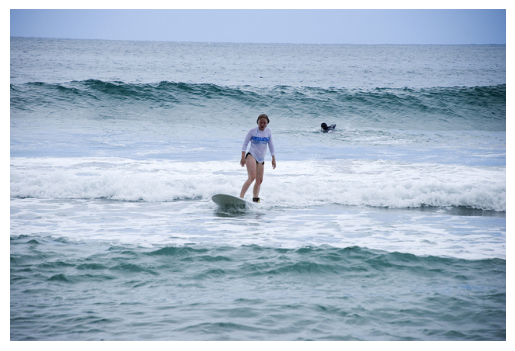

Generated caption :  ['a man riding a wave on a surfboard']
Reference caption :  ['A woman is catching a wave in the ocean on her surf board. ', 'A person on a surf board in shallow water coming ashore.', 'Young girl stands on her surfboard atop small waves.', 'A young woman is surfing in the ocean.', 'A girl in a wet suit riding a small wave.']



Image:  3


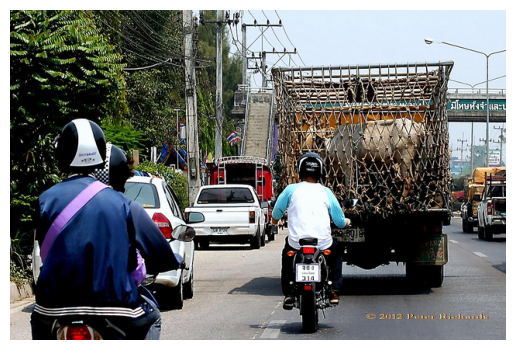

Generated caption :  ['a man riding a motorcycle on a road']
Reference caption :  ['A picture of people riding scooters in traffic behind a truck carrying live stock.', 'Two motorcycles are driving behind the traffic on a street.', 'A motorcycle is driving behind a truck with a cow.', 'A couple people on motor bikes on a city street.', 'A group of mopeds with a cow in crate on the back of a truck.']



Image:  4


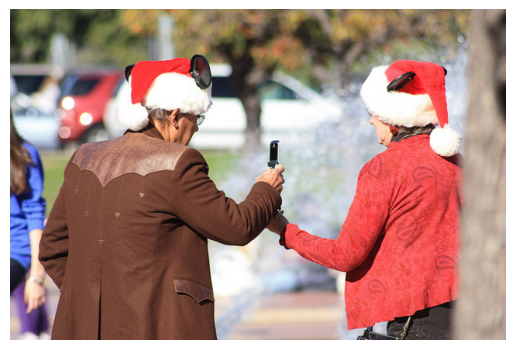

Generated caption :  ['a man in a red shirt and a woman holding a frisbee']
Reference caption :  ['A man and woman with Santa hats on while walking down a street ', 'An older man and woman with Santa hats on looking at a cell phone.', 'Elderly adults with holiday themed hats near spouting fountain outdoors.', 'A man and woman holding a cell phone with Santa hats on.', 'an old man and old woman are wearing santa hats']



Image:  5


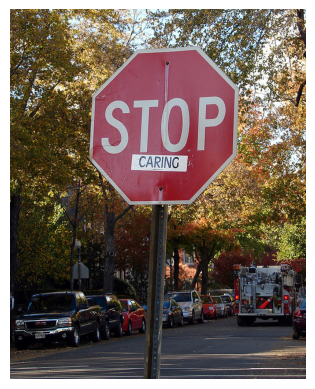

Generated caption :  ['a stop sign with a street sign on the side of the street']
Reference caption :  ['A stop sign sits on a street that is lined with cars and a firetruck sits in the distance.', 'A stop sign on a residential area has caring under the stop.', 'A vandalized stop sign stands before a a busy street.', 'The stop sign reads "Stop Caring" on it.', 'A stop sign is shown on a street lined road.']





In [110]:
# Loading the features map dictionary
features_map = torch.load('features.pt')

# Generating captions for the test image
for i, image in enumerate(random_filenames):
    
    features = features_map[image]
    features_tensor = torch.from_numpy(features).unsqueeze(0)
    
    # Generating the captions for test images and reference captions from the test df.
    generated_caption = generate_caption(features_tensor)
    reference_captions = list(test_df[test_df['file_name'] == image]['caption'])

    full_path = images_path + image
    img = Image.open(full_path).convert('RGB')
    
    print("Image: ", i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print('Generated caption : ', generated_caption)
    print('Reference caption : ', reference_captions)
    print("\n\n")

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [36]:
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])

# Load the saved features map
features_map = torch.load('features.pt')

for i, image in enumerate(test_df['file_name'].unique()):
    
    features = features_map[image] 
    
    # Convert the features to a tensor and move to the device
    features_tensor = torch.from_numpy(features).unsqueeze(0).to(device)
    
    # Generating the captions for test images and reference captions from the test df.
    generated_captions = generate_caption(features_tensor)
    reference_captions = list(test_df[test_df['file_name'] == image]['caption'])
    
    # Calculating the BLEU score between the reference and generated captions
    for generated_caption in generated_captions:
        bleu_scores = []
        for reference in reference_captions:
            bleu_score = sentence_bleu([reference.split()],generated_caption.split())
            bleu_scores.append(bleu_score)
        
        # Calculating the average BLEU score for the generated caption
        avg_bleu_score = sum(bleu_scores)/len(bleu_scores)
        
        # Adding the reference captions, generated caption, and average BLEU score to the stats df
        stats = stats.append({'ref': reference_captions, 'preds': generated_caption, 
                              'bleu': avg_bleu_score}, ignore_index=True)


In [37]:
print("Average BLEU score:", stats['bleu'].mean().round(3))

Average BLEU score: 0.447


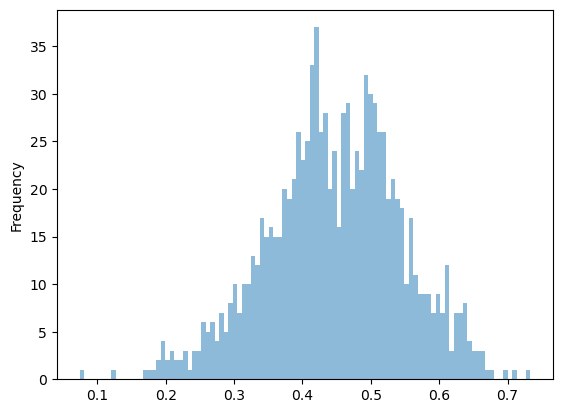

In [39]:
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

##### High BLEU Score

In [40]:
# Sort stats dataframe by BLEU score
sorted_stats = stats.sort_values('bleu')

# display the reference captions, predicted captions, for high BLEU score
print("High BLEU score")
display(HTML(sorted_stats[['bleu', 'preds', 'ref']].tail(1).rename(columns=
                                                                   {'ref': 'Reference Caption', 
                                                                    'preds': 'Predicted Caption', 
                                                                    'bleu': 'BLEU Score'}).to_html()))

High BLEU score


,BLEU Score,Predicted Caption,Reference Caption
285,0.733363,a pizza sitting on top of a wooden table,"[A pizza sitting on top of a black plate., A golden yellow pastry on a ceramic plate, Three small pieces of pizza sit on a plate. , A few pieces of pizza sit on a skillet., Three cheese pizza sticks are on a plate.]"


##### Low BLEU Score

In [41]:
# display the reference captions, predicted captions, for low BLEU score
print("Low BLEU score")
display(HTML(sorted_stats[['bleu', 'preds', 'ref']].head(1).rename(columns=
                                                                   {'ref': 'Reference Caption', 
                                                                    'preds': 'Predicted Caption', 
                                                                    'bleu': 'BLEU Score'}).to_html()))

Low BLEU score


,BLEU Score,Predicted Caption,Reference Caption
697,0.074037,a horse is riding a horse in the dirt,"[Two horses with blazes on their faces nuzzling each other., Two horses that are standing near each other., A couple of brown horses standing next to each other., There are two horses and they are in shown in black and white, The horses are very close to each other.]"


## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [42]:
from sklearn.metrics.pairwise import cosine_similarity

def get_caption_embeddings(caption):
    """
    This function will return the embedding of the captions.
    """
    embeddings = []
    for word in caption:
        try:
            idx = vocab.word2idx[word]
            embedding = decoder.embed(torch.tensor([idx]).to(device)).squeeze().detach().cpu().numpy()
            embeddings.append(embedding)
        except KeyError:
            pass
    if len(embeddings) == 0: 
        return np.zeros(decoder.embed.embedding_dim)
    else:
        return np.mean(embeddings, axis=0)


# Initialize an empty dataframe to store the cosine similarity scores
cos_sim_df = pd.DataFrame(columns=['ref_caption', 'gen_caption', 'cos_sim'])

# This loop will iterate over the reference captions and the generate captions
# Results are stored in cos_sim_df frame for each reference caption to generate caption
# Avg cosine similarity results are stored in stats for all reference caption to generate caption
for i in range(len(stats)):

    ref_caption = stats.loc[i, 'ref']
    gen_caption = stats.loc[i, 'preds']
    
    # Compute the embedding vector for the generated caption
    gen_avg_embedding = get_caption_embeddings(gen_caption.split())
    
    cosine_scores = []
    
    
    for ref in ref_caption:
        ref_avg_embedding = get_caption_embeddings(ref.split())
        cosine_sim = cosine_similarity(ref_avg_embedding.reshape(1, -1), gen_avg_embedding.reshape(1, -1))
        
        cosine_scores.append(cosine_sim[0][0])
        
        cos_sim_df = cos_sim_df.append({'ref_caption': ref, 'gen_caption': gen_caption,
                                        'cos_sim': cosine_sim[0][0]}, ignore_index=True)
    
    avg_cos_score = sum(cosine_scores)/len(cosine_scores)
    stats.loc[i, 'cos_sim'] = avg_cos_score

##### Cosine similarity score for generated caption and average vector of each reference caption

In [43]:
print("Average cosine similarity score:", cos_sim_df['cos_sim'].mean().round(3))

Average cosine similarity score: 0.364


##### Histogram of cosine similarity score for generated caption and average vector of each reference caption

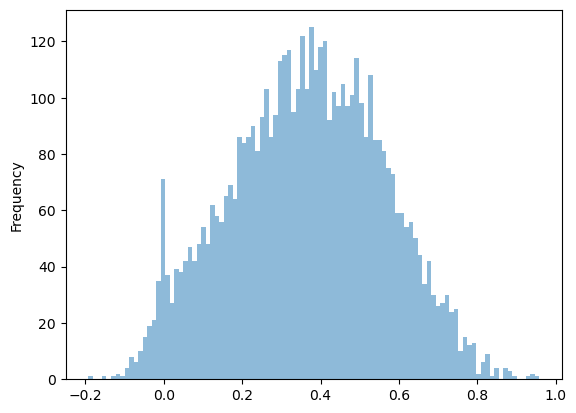

In [44]:
ax = cos_sim_df['cos_sim'].plot.hist(bins=100, alpha=0.5)

##### Cosine similarity score for generated caption and average vector of all reference caption

In [45]:
print("Average cosine similarity score:", stats['cos_sim'].mean().round(3))

Average cosine similarity score: 0.364


##### Histogram of cosine similarity score for generated caption and average vector of all reference caption

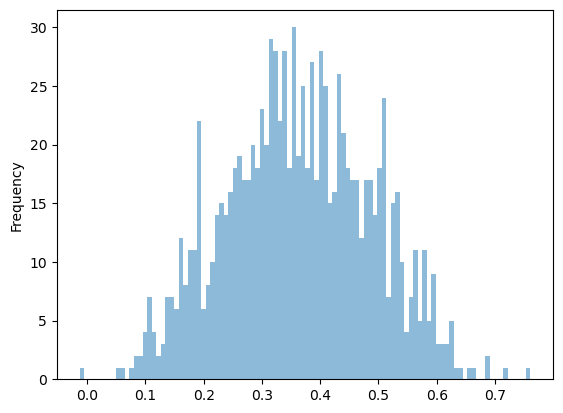

In [46]:
ax = stats['cos_sim'].plot.hist(bins=100, alpha=0.5)

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [47]:
# Sort stats dataframe by BLEU score
sorted_stats = stats.sort_values('cos_sim')

# display the reference captions, predicted captions, for high BLEU score
print("High Cosine similarity score")
display(HTML(sorted_stats[['cos_sim', 'preds', 'ref']].tail(1).
             rename(columns={'ref': 'Reference Caption', 'preds': 'Predicted Caption',
                             'cos_sim': 'Cosine Similarity Score Score'}).to_html()))

High Cosine similarity score


,Cosine Similarity Score Score,Predicted Caption,Reference Caption
541,0.761031,a man in a suit and tie with a hat,"[A close-up of a man in a suit and tie wearing a flower., an older man with a flower and a blue tie, A bald man with a mustache wearing a suit., An elderly man dressed in a black tuxedo and a blue tie., A man in a suit and blue tie with a flower in his lapel. ]"


In [48]:
# display the reference captions, predicted captions, for high BLEU score
print("Low Cosine similarity score")
display(HTML(sorted_stats[['cos_sim', 'preds', 'ref']].head(1).
             rename(columns={'ref': 'Reference Caption', 'preds': 'Predicted Caption', 
                             'cos_sim': 'Cosine Similarity Score Score'}).to_html()))

Low Cosine similarity score


,Cosine Similarity Score Score,Predicted Caption,Reference Caption
697,-0.013133,a horse is riding a horse in the dirt,"[Two horses with blazes on their faces nuzzling each other., Two horses that are standing near each other., A couple of brown horses standing next to each other., There are two horses and they are in shown in black and white, The horses are very close to each other.]"


## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [52]:
stats['rescaled_cos_sim'] = (stats['cos_sim'] + 1) / 2
print("Average cosine similarity(rescaled) score:", stats['rescaled_cos_sim'].mean().round(3))
print("Average BLEU score:", stats['bleu'].mean().round(3))

Average cosine similarity(rescaled) score: 0.682
Average BLEU score: 0.447


### **Explanation**

The BLEU and cosine similarity score are the two important metrics used to evaluate the machine translation and the text generation model. BLUE score is calculates the n-gram overlap between the predicted text and the reference text.Cosine similarity score caclculates the similarity between the predicted text and the reference text using the vector representation.BLEU score lies between 0 to 1, whereas the cosine similarity score lies between -1 to 1.

**Strengths of BLUE score**
* It is the most commonly used metric for machine translation model.
* It allows more objective analysis by comparing the generated caption with one or more reference captions.
* Easy to understand, fast, and affordable.

**Weaknesses of BLUE score**
* It consider n-grams and does not take care of semantic or syntatic information.
* It is sensitive to the length of the produced caption, thus shorter captions may receive greater scores.

**Strengths of Cosine similarity score**
* This metric is good at capturing semantic similarities and contextual information.
* Since it is vector based, a more complex relationship between the word is handled, unlike the overlap n-grams.
* It can capture the similarity between texts even if they have different lengths.

**Weaknesses of Cosine similarity score**
* It is more computational expensive to calculate the score, since it is has vectors.
* It can be affected by noise and outliers in the text data.
* It does not consider the fluency and grammaticality of the predicted text.

### **Model Performance Evaluation**
On the test set, the average BLEU score is 0.447, indicating that the performance is quite low as measured by the n-gram overlap between predicted and reference text. The alternative evaluation measure is an average cosine similarity score of 0.682, indicating that when the model is assessed based on vector similarity between predicted and reference texts, the model performs better.

Note : In order to compare the performance ,the cosine similarity score is rescaled to lie in between 0 and 1.


 #### 7.2 Analysis of individual examples (10 marks)
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

#### Similar Scores

In [113]:
stats['diff_value'] = abs(stats['bleu'] - stats['rescaled_cos_sim'])
min_stats = stats[stats['diff_value'] == stats['diff_value'].min()]
max_stats = stats[stats['diff_value'] == stats['diff_value'].max()]

# Display min stats as HTML in the notebook
print("Similar Score")
display(HTML(min_stats[['bleu','rescaled_cos_sim', 'preds', 'ref']].
             rename(columns={'ref': 'Reference Caption', 'preds': 'Predicted Caption', 
                             'rescaled_cos_sim': 'Cosine Similarity Score(Rescaled)',
                            'bleu' : 'BLEU score'}).to_html(index=False)))


Similar Score


BLEU score,Cosine Similarity Score(Rescaled),Predicted Caption,Reference Caption
0.571454,0.570253,a plate of food that is on a table,"[Grilled meat with veggies and potatoes on plate, A plate with barbecue chicken, mashed red potatoes and steamed broccoli., A plate with chicken, mashed potatoes, and broccoli on it., Grilled meat with two sides of mashed potatoes and broccoli., A plate contains meat, broccoli, and mashed potatoes. ]"


#### **Explanation**
The BLEU and cosine scores for the above captions are around 0.57. Therefore, the same scores always indicates a higher level of agreement between the predicted caption and the reference caption based on both metrics. This suggests that the predicted caption not only has a similar n-gram overlap with the reference caption but also exhibits a high degree of semantic similarity.

#### Different Scores

In [96]:
print("Different Score")
display(HTML(max_stats[['bleu','rescaled_cos_sim', 'preds', 'ref']].
             rename(columns={'ref': 'Reference Caption', 'preds': 'Predicted Caption', 
                             'rescaled_cos_sim': 'Cosine Similarity Score(Rescaled)',
                            'bleu' : 'BLEU score'}).to_html(index=False)))

Different Score


BLEU score,Cosine Similarity Score(Rescaled),Predicted Caption,Reference Caption
0.282702,0.81284,a black cat sitting on top of a bed,"[Two black cats one sitting on a chair and one next to the chair., A black cat sitting on a wooden chair beside a stereo., A sitting on a chair in front of a television., a black cat with a white collar is sitting on a chair and another black cat on the floor, A black cat sitting on a stool next to another cat on the floor.]"


#### **Explanation** 
The BLEU score for the above caption was 0.28, but the cosine similarity score was 0.81, indicating a lesser level of agreement between the anticipated and reference captions. This implies that, while the projected caption and the reference caption shared a high degree of semantic similarity, the n-gram overlap was lower. 